In [1]:
import pandas as pd

In [2]:
filepath = './../../data/data_splits_stratified/6-2-2_all_classes_enriched_with_kw/'

In [3]:
train_file = f"{filepath}train.csv"
val_file = f"{filepath}val.csv"
test_file = f"{filepath}test.csv"
# Read train, val, and test data
train_data = pd.read_csv(train_file)
val_data = pd.read_csv(val_file)
test_data = pd.read_csv(test_file)
df = pd.concat([train_data, val_data, test_data])
print(10*'*', 'Split statisistics', 10*'*')
print('Train:', len(train_data))
print('Val:', len(val_data))
print('Test:', len(test_data))
print('Total:', len(df))

********** Split statisistics **********
Train: 1581
Val: 530
Test: 534
Total: 2645


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2645 entries, 0 to 533
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   idx             2645 non-null   int64 
 1   pmid            2645 non-null   int64 
 2   journal_name    2639 non-null   object
 3   title           2645 non-null   object
 4   abstract        2645 non-null   object
 5   keywords        866 non-null    object
 6   accepted_label  2645 non-null   object
 7   multi_label     2645 non-null   int64 
 8   binary_label    2645 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 206.6+ KB


In [8]:
print('Total n journals:',df.journal_name.nunique())

Total n journals: 1262


In [5]:
jounral_counts = df.groupby('journal_name').size().sort_values(ascending=False)
print(jounral_counts[:20])

journal_name
Scientific reports                                                        31
PloS one                                                                  26
The Journal of clinical psychiatry                                        21
Journal of affective disorders                                            20
Journal of Alzheimer's disease : JAD                                      19
Neurology                                                                 17
Psychiatry research                                                       17
Epilepsy & behavior : E&B                                                 16
Journal of neurosurgery                                                   16
Neurosurgery                                                              16
Brain research                                                            15
Psychopharmacology                                                        14
Journal of neurology, neurosurgery, and psychiatry             

In [6]:
df.binary_label.value_counts()

binary_label
0    2266
1     379
Name: count, dtype: int64

In [7]:
df.accepted_label.value_counts()

accepted_label
Remaining                              858
Non-systematic-review                  371
Human-non-RCT-non-drug-intervention    206
Human-non-RCT-drug-intervention        179
Human-case-report                      165
Animal-other                           155
Animal-drug-intervention               147
Human-systematic-review                110
In-vitro-study                         104
Human-RCT-non-drug-intervention         88
Animal-non-drug-intervention            77
Human-RCT-drug-intervention             73
Clinical-study-protocol                 58
Human-RCT-non-intervention              54
Name: count, dtype: int64

In [8]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def compute_stats(df, col):
    def compute_length(text):
        return len(word_tokenize(text))
    
    # for the whole dataset
    df['abstract_length'] = df.abstract.apply(compute_length)
    dataset_stats = {
        'Whole Dataset': {
        'Min': df.abstract_length.min(),
        'Mean': int(df.abstract_length.mean()),
        'Max': df.abstract_length.max()
        }
    }

    class_stats = {}
    for label, group in df.groupby(col):
        class_stats[label] = {
            'Min': group['abstract_length'].min(),
            'Mean': int(group['abstract_length'].mean()),
            'Max': group['abstract_length'].max()
        }

    stats_df = pd.DataFrame({
        'Label': ['Whole Dataset'] + list(class_stats.keys()),
        'Min': [dataset_stats['Whole Dataset']['Min']] + [class_stats[label]['Min'] for label in class_stats],
        'Mean': [dataset_stats['Whole Dataset']['Mean']] + [class_stats[label]['Mean'] for label in class_stats],
        'Max': [dataset_stats['Whole Dataset']['Max']] + [class_stats[label]['Max'] for label in class_stats],
    })


    return stats_df

    


[nltk_data] Downloading package punkt to /Users/shtosti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
stats_df = compute_stats(df, col='accepted_label')
stats_df

,Label,Min,Mean,Max
0,Whole Dataset,17,237,1040
1,Animal-drug-intervention,68,237,509
2,Animal-non-drug-intervention,29,258,459
3,Animal-other,69,244,468
4,Clinical-study-protocol,154,318,605
5,Human-RCT-drug-intervention,58,312,1040
6,Human-RCT-non-drug-intervention,95,249,574
7,Human-RCT-non-intervention,124,313,570
8,Human-case-report,17,162,432
9,Human-non-RCT-drug-intervention,52,258,605


In [10]:
stats_df = compute_stats(df, col='binary_label')
stats_df

,Label,Min,Mean,Max
0,Whole Dataset,17,237,1040
1,0,17,235,1040
2,1,29,244,509


In [17]:
from matplotlib import pyplot as plt


def computeVisualizeStats(df, level='char'):
    """Function to compute and visualize text statistics:
    - on char level
    - on token level
    """

    def compute_lengths(text):
        if level == 'char':
            return len(text)
        elif level == 'token':
            return len(word_tokenize(text))
        else:
            raise ValueError("specify 'char' or 'token'")

    label_statistics = {}
    for label, group in df.groupby('accepted_label'):
        title_lengths = group['title'].apply(compute_lengths)
        abstract_lengths = group['abstract'].apply(compute_lengths)
        label_statistics[label] = {
            'Abstract': {
                'Mean': abstract_lengths.mean(),
                'Min': abstract_lengths.min(),
                'Max': abstract_lengths.max()
            }
        }

    # Visualization
    labels = []
    abstract_means = []
    abstract_mins = []
    abstract_maxs = []

    for label, stats in label_statistics.items():
        labels.append(label)
        abstract_means.append(stats['Abstract']['Mean'])
        abstract_mins.append(stats['Abstract']['Min'])
        abstract_maxs.append(stats['Abstract']['Max'])


    # plt.subplot(1, 2, 2)
    plt.scatter(abstract_mins, labels, color='seagreen', label='Min')
    plt.scatter(abstract_means, labels, color='mediumvioletred', label='Mean')
    plt.scatter(abstract_maxs, labels, color='steelblue', label='Max')
    # plt.title('ABSTRACT Length Statistics\n')
    plt.xlabel('Length (n tokens)', fontsize=14)
    plt.ylabel('Labels', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig('abstract_length.pdf')
    plt.show()

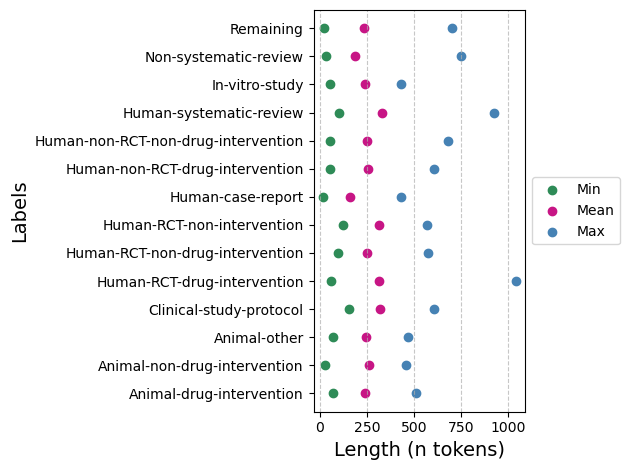

In [18]:
computeVisualizeStats(df, level='token')